In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns
import os

from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf 

# https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html
from patsy import dmatrices

#Import sklearn to run sklearn logistic reg model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
os.getcwd()
df = pd.read_csv("traffic_violation_query.csv")

In [3]:
df.head()

,Date_Key,driver_age,driver_gender,driver_race,drugs_related_stop,search_conducted,stop_date,stop_duration,stop_outcome,stop_time,violation,violation_raw
0,2,20,M,White,False,False,1/2/2005,0-15 Min,Citation,1:55:00 AM,Speeding,Speeding
1,18,40,M,White,False,False,1/18/2005,0-15 Min,Citation,8:15:00 AM,Speeding,Speeding
2,23,33,M,White,False,False,1/23/2005,0-15 Min,Citation,11:15:00 PM,Speeding,Speeding
3,51,19,M,White,False,False,2/20/2005,16+ Min,Arrest Driver,5:15:00 PM,Other,Other
4,73,21,F,White,False,False,3/14/2005,0-15 Min,Citation,10:00:00 AM,Speeding,Speeding


In [4]:
#drop these columns
df_logit = df.drop(columns={'Date_Key', 'stop_date', 'stop_time', 'violation_raw'})

We are dropping date key because it is a key we use in the fact table in Power BI. Also, stop_date and stop_duration are dropped because they would cause too many categorical variables.
Aside from this, violatin_raw was dropped because the categories are same as violation_raw. 

In [5]:
category_mapping = dict(enumerate(df_logit['driver_gender'].astype('category').cat.categories))
print(category_mapping)

category_mapping = dict(enumerate(df_logit['driver_race'].astype('category').cat.categories))
print(category_mapping)

category_mapping = dict(enumerate(df_logit['drugs_related_stop'].astype('category').cat.categories))
print(category_mapping)

category_mapping = dict(enumerate(df_logit['search_conducted'].astype('category').cat.categories))
print(category_mapping)

category_mapping = dict(enumerate(df_logit['stop_duration'].astype('category').cat.categories))
print(category_mapping)

category_mapping = dict(enumerate(df_logit['violation'].astype('category').cat.categories))
print(category_mapping)

category_mapping = dict(enumerate(df_logit['stop_outcome'].astype('category').cat.categories))
print(category_mapping)

{0: 'F', 1: 'M'}
{0: 'Black', 1: 'Hispanic', 2: 'Other', 3: 'White'}
{0: False, 1: True}
{0: False, 1: True}
{0: '0-15 Min', 1: '16+ Min'}
{0: 'Equipment', 1: 'Moving violation', 2: 'Other', 3: 'Registration/plates', 4: 'Speeding'}
{0: 'Arrest Driver', 1: 'Citation', 2: 'Other', 3: 'Warning'}


In [6]:
# convert strings to category types
df_logit['driver_gender'] = df_logit['driver_gender'].astype('category')
df_logit['driver_race'] = df_logit['driver_race'].astype('category')
df_logit['drugs_related_stop'] = df_logit['drugs_related_stop'].astype('category')
df_logit['search_conducted'] = df_logit['search_conducted'].astype('category')

df_logit['stop_duration'] = df_logit['stop_duration'].astype('category')
df_logit['violation'] = df_logit['violation'].astype('category')

df_logit['stop_outcome'] = df_logit['stop_outcome'].astype('category')

We must convert varaibles that we consider to be categories to actual categories before running the model. This is because multinomial logistic regression does not do this in the background unlike binomial logistic regression. 

In [7]:
df_logit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49193 entries, 0 to 49192
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   driver_age          49193 non-null  int64   
 1   driver_gender       49193 non-null  category
 2   driver_race         49193 non-null  category
 3   drugs_related_stop  49193 non-null  category
 4   search_conducted    49193 non-null  category
 5   stop_duration       49193 non-null  category
 6   stop_outcome        49193 non-null  category
 7   violation           49193 non-null  category
dtypes: category(7), int64(1)
memory usage: 721.8 KB


In [8]:
df_logit.head()

,driver_age,driver_gender,driver_race,drugs_related_stop,search_conducted,stop_duration,stop_outcome,violation
0,20,M,White,False,False,0-15 Min,Citation,Speeding
1,40,M,White,False,False,0-15 Min,Citation,Speeding
2,33,M,White,False,False,0-15 Min,Citation,Speeding
3,19,M,White,False,False,16+ Min,Arrest Driver,Other
4,21,F,White,False,False,0-15 Min,Citation,Speeding


In [9]:
category_mapping = {}
for col in df_logit.columns:
    if df_logit[col].dtype.name == 'category':
        category_mapping[col] = dict(enumerate(df_logit[col].cat.categories))

# Convert other categorical columns to codes
for col in df_logit.columns:
    if df_logit[col].dtype.name == 'category':
        df_logit[col] = df_logit[col].cat.codes
        

First, we will create an empty dictionary. This way we know what enurmation a category in a column belongs. To do so we use a for loop to loop through the columns and if a column is of a category data type then we will enumerate that column and assign it to a dictionary along with that column name. 

After converting category columns into category type, we must enconde them numerically to be processed in a multinomial logistic regression in python. Otherwise we will get an error. 
To do this we use a for loop to loop through all the columns and if the data type of a column is a category then we will encode this column. 


In [10]:
category_mapping

{'driver_gender': {0: 'F', 1: 'M'},
 'driver_race': {0: 'Black', 1: 'Hispanic', 2: 'Other', 3: 'White'},
 'drugs_related_stop': {0: False, 1: True},
 'search_conducted': {0: False, 1: True},
 'stop_duration': {0: '0-15 Min', 1: '16+ Min'},
 'stop_outcome': {0: 'Arrest Driver', 1: 'Citation', 2: 'Other', 3: 'Warning'},
 'violation': {0: 'Equipment',
  1: 'Moving violation',
  2: 'Other',
  3: 'Registration/plates',
  4: 'Speeding'}}

We may use this as reference whenever we need to. 

In [11]:
df_logit.head()

,driver_age,driver_gender,driver_race,drugs_related_stop,search_conducted,stop_duration,stop_outcome,violation
0,20,1,3,0,0,0,1,4
1,40,1,3,0,0,0,1,4
2,33,1,3,0,0,0,1,4
3,19,1,3,0,0,1,0,2
4,21,0,3,0,0,0,1,4


In [12]:
df_logit = df_logit.rename(columns={'violation_Moving violation': 'violation_Moving', 
                                    'violation_Registration/plates':'violation_Registration_plates',
                                   'stop_duration_0-15 Min': 'stop_duration_fif'})

Here we are renaming these specific categories for these columns to prevent errors from happening when passing them through the model. Also, it will make them in python casing. 

In [13]:
df_logit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49193 entries, 0 to 49192
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   driver_age          49193 non-null  int64
 1   driver_gender       49193 non-null  int8 
 2   driver_race         49193 non-null  int8 
 3   drugs_related_stop  49193 non-null  int8 
 4   search_conducted    49193 non-null  int8 
 5   stop_duration       49193 non-null  int8 
 6   stop_outcome        49193 non-null  int8 
 7   violation           49193 non-null  int8 
dtypes: int64(1), int8(7)
memory usage: 720.7 KB


In [14]:
formula = "stop_outcome ~ " + "+".join(df_logit.columns.difference(["stop_outcome"]))

In [15]:
# We want Multinomial Logit models
model = sm.MNLogit.from_formula(formula, data=df_logit)
result= model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.275129
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:           stop_outcome   No. Observations:                49193
Model:                        MNLogit   Df Residuals:                    49169
Method:                           MLE   Df Model:                           21
Date:                Thu, 16 Nov 2023   Pseudo R-squ.:                  0.1868
Time:                        22:40:31   Log-Likelihood:                -13534.
converged:                       True   LL-Null:                       -16643.
Covariance Type:            nonrobust   LLR p-value:                     0.000
    stop_outcome=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.3436      0.131     25.469      0.000       3.086       3.601
drive

The poor performing vairables in the outcomes were driver_gender, and drugs related stop because they are greater than 0.05, which means they fail the hypothesis test. 

In [16]:
predictions = result.predict()
print(predictions)

[[0.0062129  0.97614778 0.00376784 0.01387149]
 [0.00441521 0.97672418 0.00317818 0.01568243]
 [0.00497642 0.97662522 0.0033736  0.01502476]
 ...
 [0.04943807 0.89511809 0.027905   0.02753885]
 [0.00516274 0.97251095 0.00580735 0.01651897]
 [0.00570489 0.97637902 0.00361121 0.01430489]]


In [17]:
type(predictions)

numpy.ndarray

In [18]:
predictions.shape

(49193, 4)

We use the the entire data set to make predictions and see the results. 
Note that this is just testing things out and we will later perform training and testing.

Also, it is important to note that our predictions are stored as a numpy array and has 4 dimensions. It makes sense that there are 4 dimensions as there are 4 outcome categories. However, we must note that once we store our true outcomes into a variable it will be stored as a one dimension. The solution is to make it into 1 axis using argmax to change the axis. 

In [19]:
predicted_classes = np.argmax(predictions, axis=1)

In [20]:
predicted_classes

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [21]:
predicted_classes.shape

(49193,)

In [22]:
true_classes = df_logit['stop_outcome']

In [23]:
category_mapping

{'driver_gender': {0: 'F', 1: 'M'},
 'driver_race': {0: 'Black', 1: 'Hispanic', 2: 'Other', 3: 'White'},
 'drugs_related_stop': {0: False, 1: True},
 'search_conducted': {0: False, 1: True},
 'stop_duration': {0: '0-15 Min', 1: '16+ Min'},
 'stop_outcome': {0: 'Arrest Driver', 1: 'Citation', 2: 'Other', 3: 'Warning'},
 'violation': {0: 'Equipment',
  1: 'Moving violation',
  2: 'Other',
  3: 'Registration/plates',
  4: 'Speeding'}}

In [24]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)

[[  263  1375     0     0]
 [  280 45327     0     0]
 [   78   750     0     0]
 [   10  1110     0     0]]


Without digging deeper we already see some potential issues with our model right away. This is because he have categores but 2 of those columns have all 0s.

We can see this in the following visulization we create up next.

Text(159.0, 0.5, 'Truth')

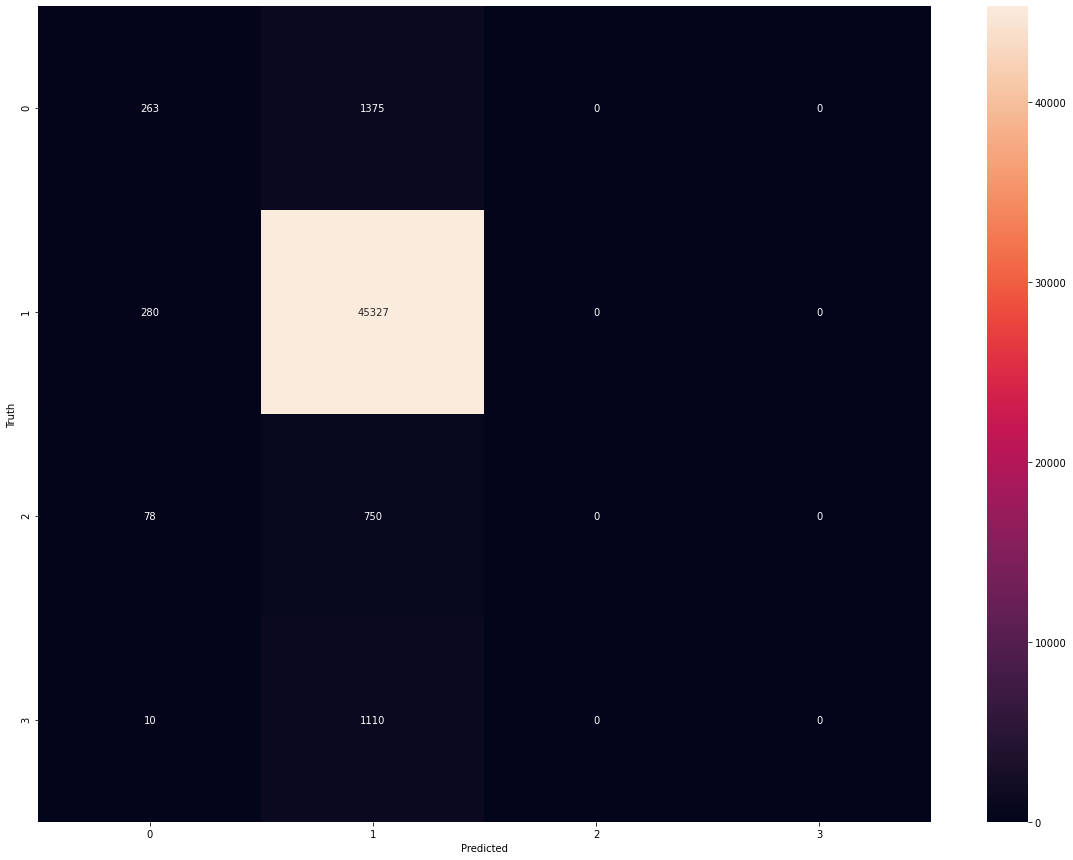

In [25]:
plt.figure(figsize=(20,15))
sns.heatmap(conf_matrix ,annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [26]:
print(classification_report(true_classes, predicted_classes, zero_division=1)) 
# must use zero_division equal to 1 to avoid division by zero

              precision    recall  f1-score   support

           0       0.42      0.16      0.23      1638
           1       0.93      0.99      0.96     45607
           2       1.00      0.00      0.00       828
           3       1.00      0.00      0.00      1120

    accuracy                           0.93     49193
   macro avg       0.84      0.29      0.30     49193
weighted avg       0.92      0.93      0.90     49193



We have an issue! 

There are recalls of 0 for 2 and 3. This means that the model itself failed to identify any of positive instances. Thus, the model did not capture any of the true positives which resulted in a recall failure for the positive instances in the dataset. 

Likewise, classes 2 and 3 have an f1 score of 0, which is a result of of the recall being 0. This means that the model cannot identify any of the positive instances for these classes. Also, note that the precision is 1 for both these classes. Meaning that there is inability to balance precision and recall effectively.

We can try one things though. Specifically, we can decrease the cutoff rate in hopes of gaining some positive insights. The poor outcome may be linked to there being very few observations for the "Other" (2) class and Warning (3) class, which translates to high correlation.  We can see the histogram and heatmap to verify this suspecion back in Power BI. 

In [27]:
# Adjusting cutoff rate
cutoff = 0.5  # change cutoff rate

# Adjust the decision boundaries based on the predicted probabilities
adjusted_predictions = np.where(predictions > cutoff, 1, 0)  # Adjust the threshold according to the cutoff

# Get the classes based on the adjusted predictions
adjusted_predicted_classes = np.argmax(adjusted_predictions, axis=1)



# Print the classification report with the adjusted cutoff rate
print(classification_report(true_classes, adjusted_predicted_classes, zero_division=1))




              precision    recall  f1-score   support

           0       0.41      0.21      0.27      1638
           1       0.94      0.99      0.96     45607
           2       1.00      0.00      0.00       828
           3       1.00      0.00      0.00      1120

    accuracy                           0.93     49193
   macro avg       0.84      0.30      0.31     49193
weighted avg       0.92      0.93      0.90     49193



First let us the change the cutoff to 0.5 to see of there is a benifit. This normally helps capture more observations all accross. However, not in this case. 

In [28]:
# Adjusting the cutoff rate
cutoff = 0.2  # Adjust the cutoff rate as needed

# Adjust the decision boundaries based on the predicted probabilities
adjusted_predictions = np.where(predictions > cutoff, 1, 0)  # Adjust the threshold according to the cutoff

# Get the classes based on the adjusted predictions
adjusted_predicted_classes = np.argmax(adjusted_predictions, axis=1)



# Print the classification report with the adjusted cutoff rate
print(classification_report(true_classes, adjusted_predicted_classes, zero_division=1))



              precision    recall  f1-score   support

           0       0.40      0.39      0.40      1638
           1       0.94      0.98      0.96     45607
           2       1.00      0.00      0.00       828
           3       1.00      0.00      0.00      1120

    accuracy                           0.92     49193
   macro avg       0.84      0.34      0.34     49193
weighted avg       0.93      0.92      0.90     49193



Again we changed the cutoff rate to a lower rate. However, there was no change or improvement.

Now we will change the cutoff individually. 

In [29]:
# We can also define cutoffs for each outcome varaible.

# Adjusting the threshold for each class individually
class_thresholds = [0.5, 0.5, 0.5, 0.5]  # Adjust the thresholds for each class as needed

adjusted_predictions = np.zeros_like(predictions)
for i in range(len(class_thresholds)):
    adjusted_predictions[:, i] = (predictions[:, i] > class_thresholds[i]).astype(int)

# Get the classes based on the adjusted predictions
adjusted_predicted_classes = np.argmax(adjusted_predictions, axis=1)



# Print the classification report with the adjusted thresholds for each class
print(classification_report(true_classes, adjusted_predicted_classes, zero_division=1))


              precision    recall  f1-score   support

           0       0.41      0.21      0.27      1638
           1       0.94      0.99      0.96     45607
           2       1.00      0.00      0.00       828
           3       1.00      0.00      0.00      1120

    accuracy                           0.93     49193
   macro avg       0.84      0.30      0.31     49193
weighted avg       0.92      0.93      0.90     49193



Here we can change the cutoff for each class to 0.5 to ensure the output is the same as applying 0.5 to all the classes, which it is.

To do this we create a list with our desired cutoff rates for each class. Then we create an array of zeroes with the same shape and data type as the input array. The reason for this is because we want to initialize a container to store adjusted predictions. 

After this, we use a for loop to iterate over each class index (i) and ranges from 0 to 3 becasue we have 4 classes. From here our loop goes to compare thresholds by comparing the predicted probablities for the current class "i" in all rows. It checks if each probablity than the specified cutoff for that class in "class_thresholds[i]" in all rows. 
The comparison result ends up in a boolean but then we change it to an integer where True is converted to 1 and False to 0. Finally, we assign teh array of 1s and 0s to the 'i' th column of the adjusted predictions array. Each column corresponds to a different class. 

In [30]:
# We can also define cutoffs for each outcome varaible.

# Adjusting the threshold for each class individually
class_thresholds = [0.5, 0.5, 0.2, 0.2]  # Adjust the thresholds for each class as needed

adjusted_predictions = np.zeros_like(predictions)
for i in range(len(class_thresholds)):
    adjusted_predictions[:, i] = (predictions[:, i] > class_thresholds[i]).astype(int)

# Get the classes based on the adjusted predictions
adjusted_predicted_classes = np.argmax(adjusted_predictions, axis=1)



# Print the classification report with the adjusted thresholds for each class
print(classification_report(true_classes, adjusted_predicted_classes, zero_division=1))


              precision    recall  f1-score   support

           0       0.42      0.20      0.27      1638
           1       0.94      0.99      0.96     45607
           2       0.32      0.01      0.02       828
           3       1.00      0.00      0.00      1120

    accuracy                           0.93     49193
   macro avg       0.67      0.30      0.31     49193
weighted avg       0.91      0.93      0.90     49193



Now we held the cutoff for the first 2 classes the same, except that for the last 2 we chagned the cutoff to 0.2. This was because they have the lowest amount of observations, which only made a difference for class 2 which was a very miniscul amount. 







Nonetheless, we will further explore and split the data into to train and test our model. 

In [31]:
### training data
df_log_train_x = df_logit.sample(frac=0.8, random_state=1)
df_log_train_y = df_log_train_x['stop_outcome']

df_log_train_ydf = df_log_train_x[['stop_outcome']]
### testing data
df_log_test_x = df_logit.drop(df_log_train_x.index)
df_log_test_y = df_logit['stop_outcome'].drop(df_log_train_ydf.index)

In [32]:
df_log_test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9839 entries, 9 to 49192
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   driver_age          9839 non-null   int64
 1   driver_gender       9839 non-null   int8 
 2   driver_race         9839 non-null   int8 
 3   drugs_related_stop  9839 non-null   int8 
 4   search_conducted    9839 non-null   int8 
 5   stop_duration       9839 non-null   int8 
 6   stop_outcome        9839 non-null   int8 
 7   violation           9839 non-null   int8 
dtypes: int64(1), int8(7)
memory usage: 221.0 KB


In [33]:
formula2 = "stop_outcome ~ " + "+".join(df_log_train_x.columns.difference(["stop_outcome"]))
model = sm.MNLogit.from_formula(formula2, data=df_log_train_x)
result= model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.274032
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:           stop_outcome   No. Observations:                39354
Model:                        MNLogit   Df Residuals:                    39330
Method:                           MLE   Df Model:                           21
Date:                Thu, 16 Nov 2023   Pseudo R-squ.:                  0.1872
Time:                        22:45:19   Log-Likelihood:                -10784.
converged:                       True   LL-Null:                       -13268.
Covariance Type:            nonrobust   LLR p-value:                     0.000
    stop_outcome=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.3042      0.146     22.667      0.000       3.018       3.590
drive

The results are similar so far. ALso, we will conduct predictions using our testing predictors as inputs. 

In [34]:
predictions = result.predict(df_log_test_x)
print(predictions)

              0         1         2         3
9      0.006225  0.981203  0.003478  0.009094
14     0.004696  0.976897  0.003334  0.015073
15     0.005927  0.976635  0.003647  0.013791
18     0.003444  0.972823  0.004811  0.018922
20     0.008281  0.907778  0.022928  0.061012
...         ...       ...       ...       ...
49178  0.017866  0.854577  0.053331  0.074227
49181  0.051387  0.929906  0.009327  0.009379
49184  0.004371  0.976896  0.003243  0.015489
49191  0.005111  0.972997  0.005602  0.016290
49192  0.005719  0.976703  0.003597  0.013981

[9839 rows x 4 columns]


In [35]:
type(predictions)

pandas.core.frame.DataFrame

In [36]:
predicted_classes_t = np.argmax(predictions.values, axis=1)

Likewise we will convert predictions into a single axis with all the predictions. 

In [37]:
predicted_classes_t.shape

(9839,)

In [38]:
type(predicted_classes_t)

numpy.ndarray

In [39]:
conf_t = confusion_matrix(df_log_test_y, predicted_classes_t)
print(conf_t)

[[  51  268    0    0]
 [  71 9039    0    0]
 [  16  147    0    0]
 [   2  245    0    0]]


The results are similar in the sense that classes 3 and 4 were not accounted for and we may see this in greater depth in the upcoming heatmap. 

Text(159.0, 0.5, 'Truth')

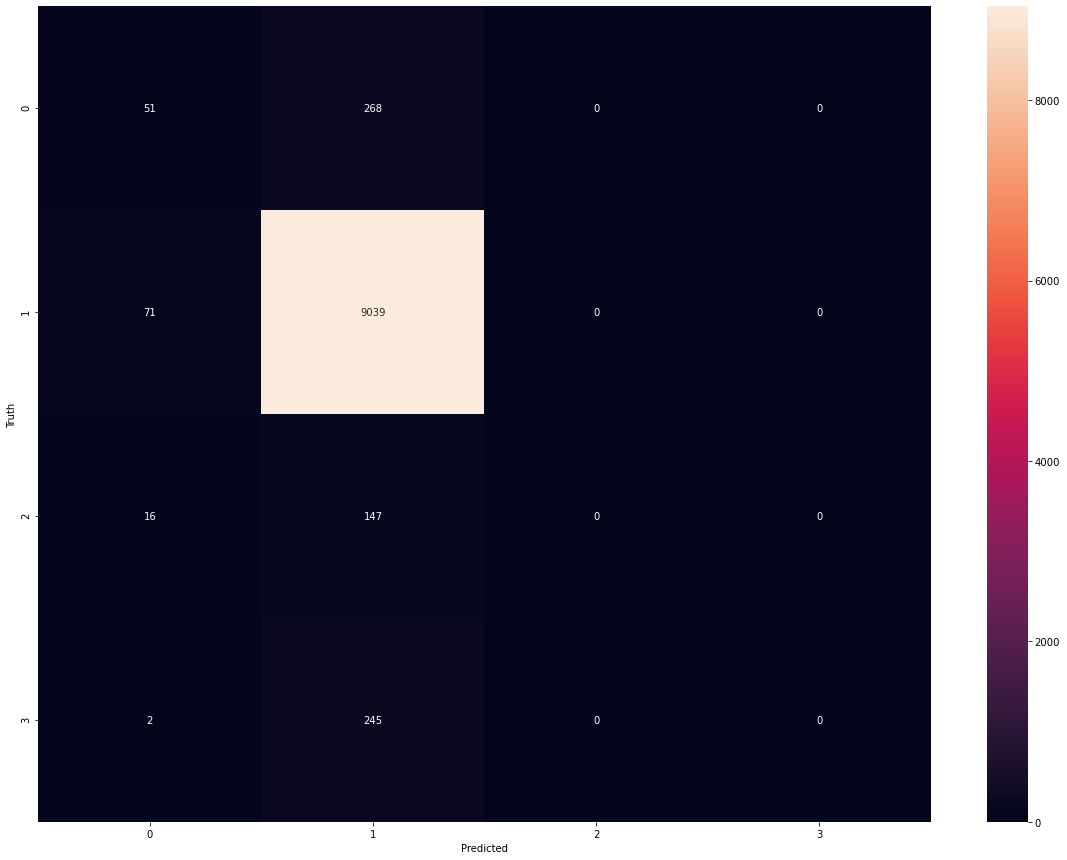

In [40]:
plt.figure(figsize=(20,15))
sns.heatmap(conf_t ,annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [41]:
print(classification_report(df_log_test_y, predicted_classes_t, zero_division=1)) 

              precision    recall  f1-score   support

           0       0.36      0.16      0.22       319
           1       0.93      0.99      0.96      9110
           2       1.00      0.00      0.00       163
           3       1.00      0.00      0.00       247

    accuracy                           0.92      9839
   macro avg       0.82      0.29      0.30      9839
weighted avg       0.92      0.92      0.90      9839



Again the results are not the best. However, we will adjust the cutoff rate. 

In [42]:
# Adjusting the cutoff rate
cutoff = 0.5  # Change cutoff rate

# Adjust the decision boundaries based on predicted probs
adjusted_preds = np.where(predictions > cutoff, 1, 0)  # Adjust the threshold according to the cutoff

# Get the classes based on the adjusted predictions
adjusted_predicted_tra = np.argmax(adjusted_preds, axis=1)



# Print the classification report with the adjusted cutoff rate
print(classification_report(df_log_test_y, adjusted_predicted_tra, zero_division=1))


              precision    recall  f1-score   support

           0       0.37      0.19      0.25       319
           1       0.93      0.99      0.96      9110
           2       1.00      0.00      0.00       163
           3       1.00      0.00      0.00       247

    accuracy                           0.92      9839
   macro avg       0.82      0.30      0.30      9839
weighted avg       0.92      0.92      0.90      9839



In [43]:
# Adjusting the cutoff rate
cutoff = 0.2  # Change cutoff rate

# Adjust the decision boundaries based on the predicted probabilities
adjusted_preds = np.where(predictions > cutoff, 1, 0)  # Adjust the threshold according to the cutoff

# Get the classes based on the adjusted predictions
adjusted_predicted_tra = np.argmax(adjusted_preds, axis=1)



# Print the classification report with the adjusted cutoff rate
print(classification_report(df_log_test_y, adjusted_predicted_tra, zero_division=1))


              precision    recall  f1-score   support

           0       0.40      0.42      0.41       319
           1       0.94      0.98      0.96      9110
           2       1.00      0.00      0.00       163
           3       1.00      0.00      0.00       247

    accuracy                           0.92      9839
   macro avg       0.83      0.35      0.34      9839
weighted avg       0.93      0.92      0.90      9839



Even after the fact that we decreased the cutoff we have no improvement. Now we will change the cutoff individually specifically for classes 3 and 4.

In [44]:
# We can also define cutoffs for each outcome varaible.

# Adjusting the threshold for each class individually
class_thresholds = [0.5, 0.5, 0.2, 0.2]  # Adjust the thresholds for each class as needed

adjusted_predictions = np.zeros_like(predicted_classes_t)
for i in range(len(class_thresholds)):
    adjusted_predictions = np.where(predictions > class_thresholds, 1, 0)


# Get classes based on adjusted predictions
adjusted_predicted_classes = np.argmax(adjusted_predictions, axis=1)




print(classification_report(df_log_test_y, adjusted_predicted_classes, zero_division=1))


              precision    recall  f1-score   support

           0       0.38      0.19      0.25       319
           1       0.93      0.99      0.96      9110
           2       0.00      0.00      0.00       163
           3       1.00      0.00      0.00       247

    accuracy                           0.92      9839
   macro avg       0.58      0.29      0.30      9839
weighted avg       0.90      0.92      0.90      9839



Still no improvement. 

In [46]:
mtrx = confusion_matrix(df_log_test_y, adjusted_predicted_classes)

Text(159.0, 0.5, 'Truth')

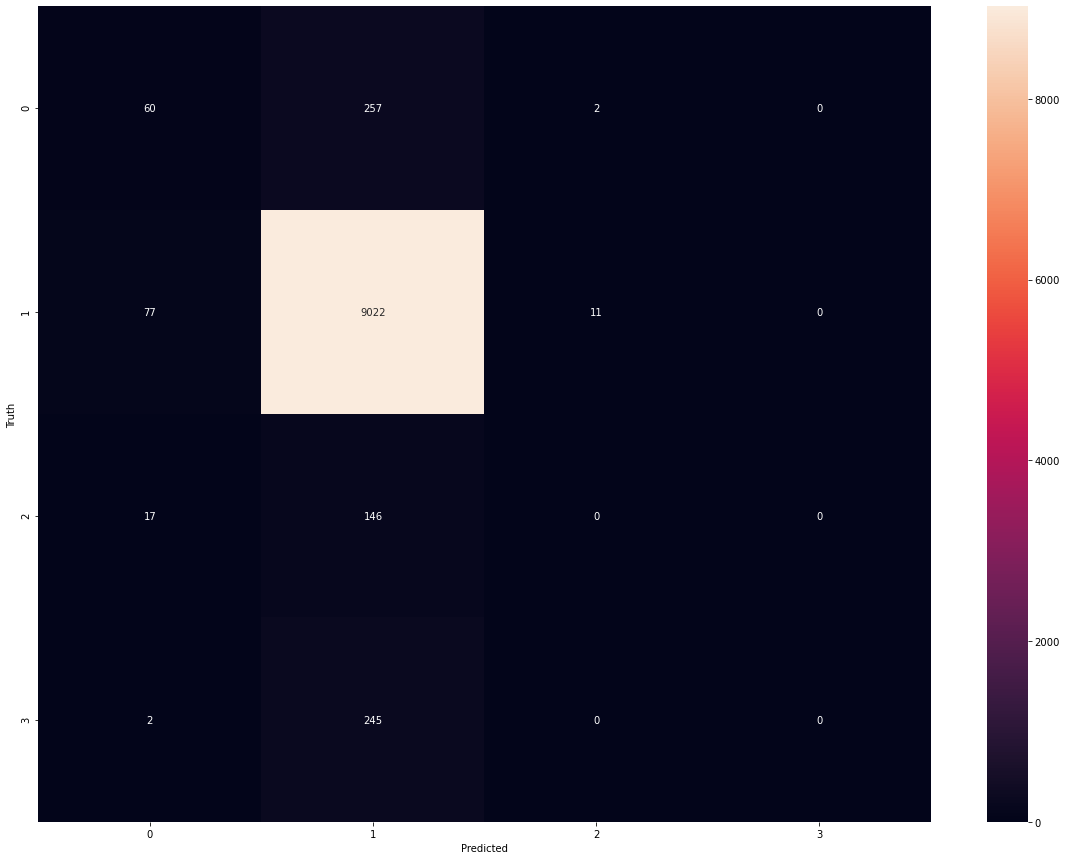

In [47]:
plt.figure(figsize=(20,15))
sns.heatmap(mtrx ,annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Now we will do some further configurations and either combine categories or drop categories.


Specifically, when revisiting our Power BI heatmap, we see a few intresting details. First, when looking at the outcome categories we see that there appears to be a high correlation between driver_race_black and driver_race_hispanic. This is likely to there being 

# Uncorrelated Attempt

Now that we saw some highcorrelation, we will combine some of the categorical variables to see if that resolves the issue. 

In [48]:
df_logit3 = df.drop(columns={'Date_Key', 'stop_date', 'stop_time', 'violation_raw'})

Again we will drop columns that were previously deemed unnecessary.

In [50]:
df_logit3['driver_race'].unique()

array(['White', 'Black', 'Other', 'Hispanic'], dtype=object)

In [51]:
df_logit3['driver_race'] = df_logit3['driver_race'].replace('Hispanic', 'Other')

In [52]:
df_logit3['driver_race'].unique()

array(['White', 'Black', 'Other'], dtype=object)

We converted Hispanic into other becasue of the high correlation with white. We did not want to convert black drivers into other because there were more observations and would like to see our results in a heatmap 

In [53]:
df_logit3['stop_outcome'].unique()

array(['Citation', 'Arrest Driver', 'Other', 'Warning'], dtype=object)

In [54]:
df_logit3['stop_outcome'] = df_logit3['stop_outcome'].replace('Warning', 'Other')
df_logit3['stop_outcome'] = df_logit3['stop_outcome'].replace('Arrest Driver', 'Other')

In [55]:
df_logit3['stop_outcome'].unique()

array(['Citation', 'Other'], dtype=object)

We will only have 2 outcome categories because the other 2 have a high correlation. Making this into a binomial logistical regression model. 

In [56]:
df_logit3['violation'].unique()

array(['Speeding', 'Other', 'Equipment', 'Moving violation',
       'Registration/plates'], dtype=object)

In [57]:
df_logit3['violation'] = df_logit3['violation'].replace('Speeding', 'Moving violation')

In [58]:
df_logit3['violation'].unique()

array(['Moving violation', 'Other', 'Equipment', 'Registration/plates'],
      dtype=object)

Speeding and moving violation are highly correlated. We do not know why. However, one reason is that speeding and moving violation may be interpreted the same sometimes. Thus we will make speeding into moving violation since it is a moving violation.

In [59]:
df_logit3 = df_logit3.rename(columns={'violation_Moving violation': 'violation_Moving', 
                                    'violation_Registration/plates':'violation_Registration_plates',
                                   'stop_duration_0-15 Min': 'stop_duration_fif'})

In [60]:
df_logit3.head()

,driver_age,driver_gender,driver_race,drugs_related_stop,search_conducted,stop_duration,stop_outcome,violation
0,20,M,White,False,False,0-15 Min,Citation,Moving violation
1,40,M,White,False,False,0-15 Min,Citation,Moving violation
2,33,M,White,False,False,0-15 Min,Citation,Moving violation
3,19,M,White,False,False,16+ Min,Other,Other
4,21,F,White,False,False,0-15 Min,Citation,Moving violation


In [61]:
df_dummy = df_logit3

we must make categorical variables into dummies since the binary model does this for us automatically and do not make them categorical before the model. 

In [62]:
heat_map = pd.get_dummies(df_dummy, columns=['driver_gender', 'driver_race', 'drugs_related_stop', 'search_conducted', 'stop_duration', 'stop_outcome', 'violation'])

In [63]:
heat_map = heat_map.drop(columns=['driver_gender_F', 'drugs_related_stop_False', 'search_conducted_False', 'stop_duration_16+ Min', 'stop_outcome_Other'])

We only need 1 column for cateogrical predictors that have 2 classes. 

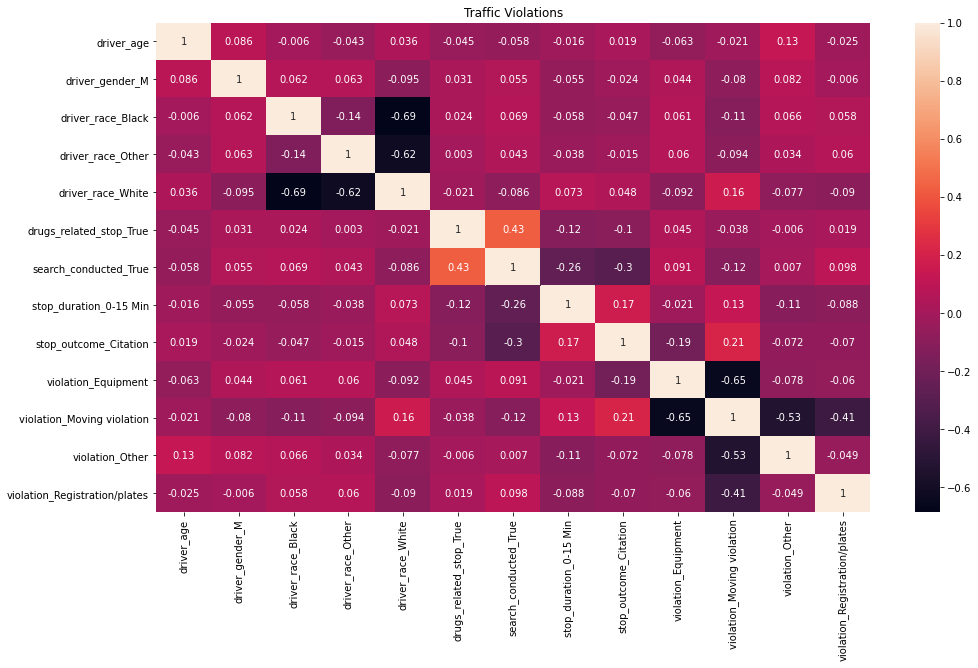

In [64]:
heat_corr = heat_map.corr().round(3)
plt.figure(figsize=(16,9))
plt.title('Traffic Violations')
sns.heatmap(heat_corr, annot=True)

plt.show()


Again we have high correlation among certain predictors like black and white drivers. However, there seems to be some improvement. 

Nonetheless, we will change black into other. 

In [65]:
df_logit3['driver_race'].unique()

array(['White', 'Black', 'Other'], dtype=object)

In [66]:
df_logit3['driver_race'] = df_logit3['driver_race'].replace('Black', 'Other')

In [67]:
df_logit3['driver_race'].unique()

array(['White', 'Other'], dtype=object)

In [68]:
df_dummy = df_logit3
heat_map = pd.get_dummies(df_dummy, columns=['driver_gender', 'driver_race', 'drugs_related_stop', 'search_conducted', 'stop_duration', 'stop_outcome', 'violation'])

In [69]:
heat_map = heat_map.drop(columns=['driver_gender_F', 'drugs_related_stop_False', 'search_conducted_False', 'stop_duration_16+ Min', 'stop_outcome_Other', 'driver_race_Other'])

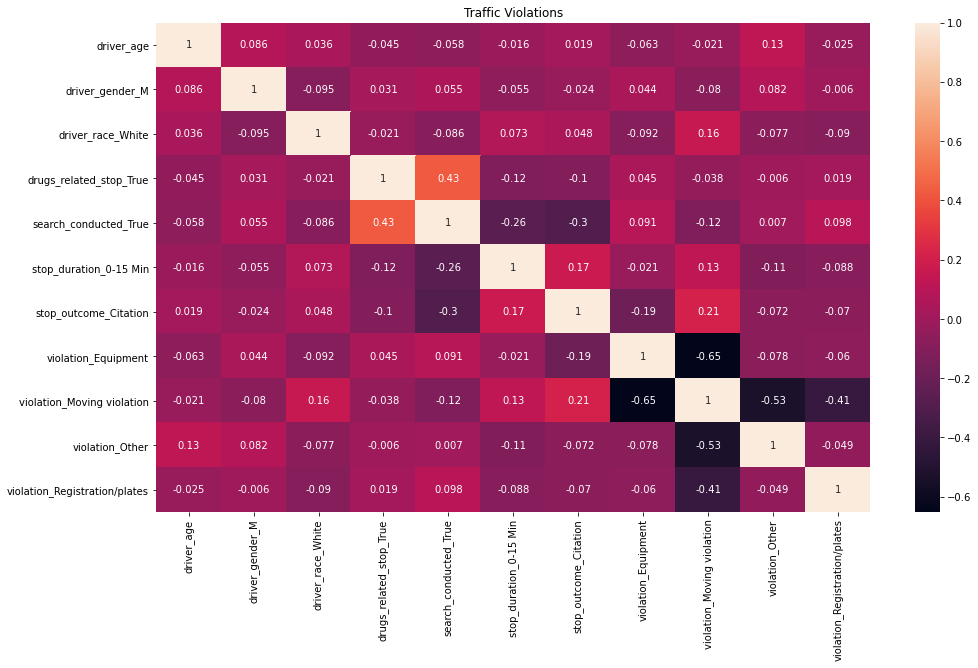

In [70]:
heat_corr = heat_map.corr().round(3)
plt.figure(figsize=(16,9))
plt.title('Traffic Violations')
sns.heatmap(heat_corr, annot=True)

plt.show()

Although there is some correlation between the violation categories, we will proceed and see the results. Also, we will be using a binary classification. 

In [71]:
### training data
df_log_train_x_bin = df_logit3.sample(frac=0.8, random_state=1)
df_log_train_y_bin = df_log_train_x['stop_outcome']

df_log_train_y_bin = df_log_train_x[['stop_outcome']]
### testing data
df_log_test_x_bin = df_logit3.drop(df_log_train_x_bin.index)
df_log_test_y_bin = df_logit3['stop_outcome'].drop(df_log_train_y_bin.index)

In [72]:
form3 = "stop_outcome ~" + "+".join(df_log_train_x_bin.columns.difference(["stop_outcome"]))
model_bin = smf.glm(formula=form3, data=df_log_train_x_bin, family=sm.families.Binomial())
result_train = model_bin.fit()
print(result_train.summary())

                                 Generalized Linear Model Regression Results                                 
Dep. Variable:     ['stop_outcome[Citation]', 'stop_outcome[Other]']   No. Observations:                39354
Model:                                                           GLM   Df Residuals:                    39344
Model Family:                                               Binomial   Df Model:                            9
Link Function:                                                 logit   Scale:                          1.0000
Method:                                                         IRLS   Log-Likelihood:                -8569.4
Date:                                               Thu, 16 Nov 2023   Deviance:                       17139.
Time:                                                       23:32:56   Pearson chi2:                 3.75e+04
No. Iterations:                                                    6                                         
Covariance

Again there is high p-values. We are left with one option, which is to drop a few of those predictors and see the results. We will drop driver_age since it is the one with the highest age. 

In [73]:
df_logit4 = df_logit3

In [74]:
df_logit4 = df_logit3.drop(columns=['driver_age'])

In [75]:
### training data
df_log_train_x_bin = df_logit4.sample(frac=0.8, random_state=1)
df_log_train_y_bin = df_log_train_x['stop_outcome']

df_log_train_y_bin = df_log_train_x[['stop_outcome']]
### testing data
df_log_test_x_bin = df_logit4.drop(df_log_train_x_bin.index)
df_log_test_y_bin = df_logit4['stop_outcome'].drop(df_log_train_y_bin.index)

In [76]:
form4 = "stop_outcome ~" + "+".join(df_log_train_x_bin.columns.difference(["stop_outcome"]))
model_bin = smf.glm(formula=form4, data=df_log_train_x_bin, family=sm.families.Binomial())
result_train = model_bin.fit()
print(result_train.summary())

                                 Generalized Linear Model Regression Results                                 
Dep. Variable:     ['stop_outcome[Citation]', 'stop_outcome[Other]']   No. Observations:                39354
Model:                                                           GLM   Df Residuals:                    39345
Model Family:                                               Binomial   Df Model:                            8
Link Function:                                                 logit   Scale:                          1.0000
Method:                                                         IRLS   Log-Likelihood:                -8569.6
Date:                                               Thu, 16 Nov 2023   Deviance:                       17139.
Time:                                                       23:33:33   Pearson chi2:                 3.75e+04
No. Iterations:                                                    6                                         
Covariance

This time we will drop all p-values greater than 0.05.

In [77]:
df_logit4 = df_logit4.drop(columns=['driver_gender','driver_race'])

In [78]:
df_logit4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49193 entries, 0 to 49192
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   drugs_related_stop  49193 non-null  bool  
 1   search_conducted    49193 non-null  bool  
 2   stop_duration       49193 non-null  object
 3   stop_outcome        49193 non-null  object
 4   violation           49193 non-null  object
dtypes: bool(2), object(3)
memory usage: 1.2+ MB


In [79]:
df_logit4['stop_outcome'].unique()

array(['Citation', 'Other'], dtype=object)

In [80]:
df_logit4['stop_outcome'] = df_logit4['stop_outcome'].replace('Other', 'False')
# change other to false and Citation to True

In [81]:
df_logit4['stop_outcome'] = df_logit4['stop_outcome'].replace('Citation', 'True')

In [82]:
df_logit4['stop_outcome'].unique()

array(['True', 'False'], dtype=object)

In [83]:
### training data
df_log_train_x_bin = df_logit4.sample(frac=0.8, random_state=1)
df_log_train_y_bin = df_log_train_x_bin['stop_outcome']

df_log_train_y_bin = df_log_train_x_bin[['stop_outcome']]
### testing data
df_log_test_x_bin = df_logit4.drop(df_log_train_x_bin.index)
df_log_test_y_bin = df_logit4['stop_outcome'].drop(df_log_train_y_bin.index)

In [84]:
form4 = "stop_outcome ~" + "+".join(df_log_train_x_bin.columns.difference(["stop_outcome"]))
model_bin = smf.glm(formula=form4, data=df_log_train_x_bin, family=sm.families.Binomial())
result_train = model_bin.fit()
print(result_train.summary())

                               Generalized Linear Model Regression Results                               
Dep. Variable:     ['stop_outcome[False]', 'stop_outcome[True]']   No. Observations:                39354
Model:                                                       GLM   Df Residuals:                    39347
Model Family:                                           Binomial   Df Model:                            6
Link Function:                                             logit   Scale:                          1.0000
Method:                                                     IRLS   Log-Likelihood:                -8570.7
Date:                                           Thu, 16 Nov 2023   Deviance:                       17141.
Time:                                                   23:33:50   Pearson chi2:                 3.74e+04
No. Iterations:                                                6                                         
Covariance Type:                              

Finally we can implement our model.

In [85]:
predictions = result_train.predict(df_log_test_x_bin)

In [86]:
predictions

9        0.030439
14       0.030439
15       0.030439
18       0.030439
20       0.030439
           ...   
49178    0.150432
49181    0.154656
49184    0.030439
49191    0.030439
49192    0.030439
Length: 9839, dtype: float64

In [87]:
# Convert 'False' to 0 and 'True' to 1 in true labels
df_log_test_y_binz = df_log_test_y_bin.map({'False': 1, 'True': 0}) # convert the actual outcome to a number 
## to be the same as the predicted data type
predicted_classes_binx = np.where(predictions < 0.5, 0, 1)
# Now, both true labels and predicted classes are of the same type (int)
print(classification_report(df_log_test_y_binz, predicted_classes_binx, zero_division=1))


              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9110
           1       0.46      0.10      0.16       729

    accuracy                           0.92      9839
   macro avg       0.70      0.54      0.56      9839
weighted avg       0.90      0.92      0.90      9839



First we must conver the actual outcomes into 1 and 0 since they are not binary. Note that we must make false into 1 and 1 true into 0. This is because stop_outcome false is listed first and thus it is considered 1. 

Aside from this there is an improvement. Specifcally, our accurcary is 92%. However, we must note that the model is flawed as it is extremly good at predicting 0s but very bad at predicting 1s. This is becasue there are very few observations for 1.

In [92]:
conf_matrix_bin = confusion_matrix(df_log_test_y_binz, predicted_classes_binx)
print("Confusion Matrix:")
print(conf_matrix_bin)

Confusion Matrix:
[[9026   84]
 [ 658   71]]


Text(159.0, 0.5, 'Truth')

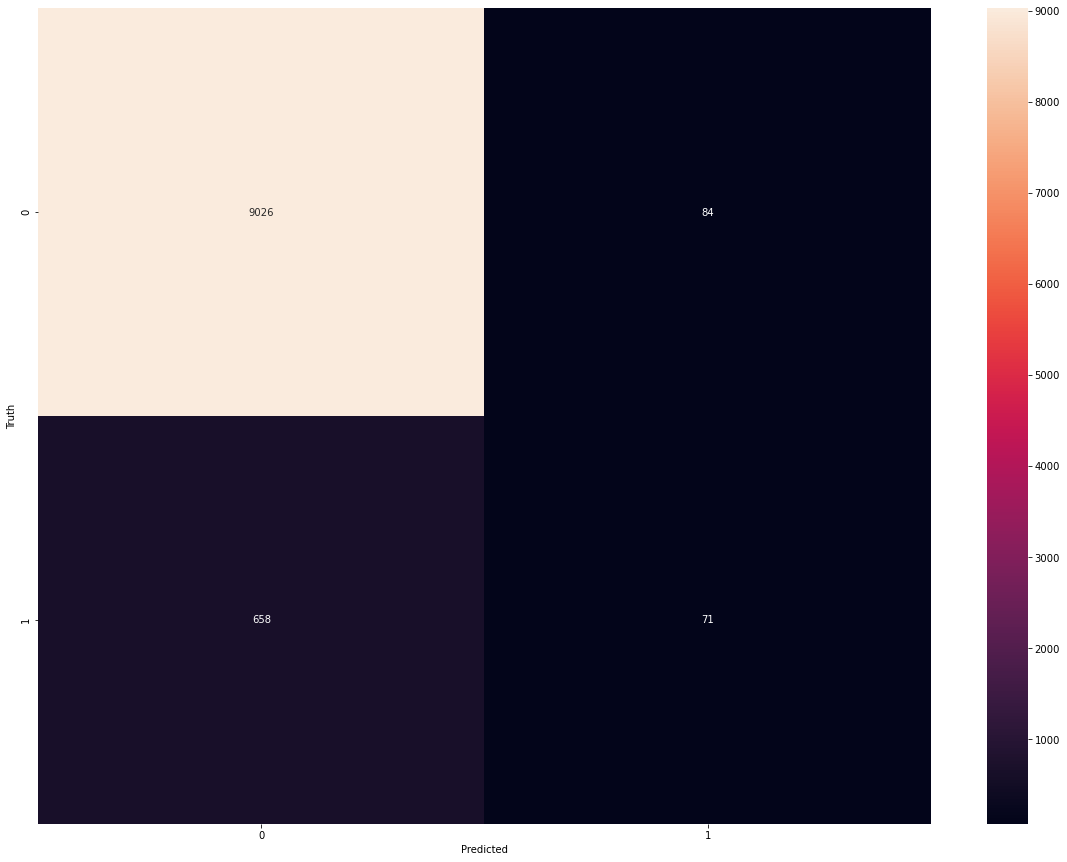

In [95]:
plt.figure(figsize=(20,15))
sns.heatmap(conf_matrix_bin ,annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Develop Code for Power Query Dataframe

We will creat a dataframe for power query and pass that into power bi itself. First we must create a dataframe with both our predicted column and actual results. This will help visualize things.

In [93]:
df_predic_true = pd.DataFrame(predicted_classes_binx)
df_predic_true = df_predic_true.rename(columns={0: 'Predicted'})

In [94]:
df_predic_true['Actual'] = pd.DataFrame(df_log_test_y_binz).reset_index().drop(columns=['index'])


In [90]:
df_predic_true

,Predicted,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
9834,0,1
9835,0,0
9836,0,0
9837,0,0
